In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import get_data, min_max_normalize, prepare_data, create_dataloaders, set_seed
from model import MembraneModel, Trainer

# set seed for reproducibility
set_seed(42)

# Pfade
data_csv = '../../../data/interpolation/auswertung_gesamt_8N_10N_12N_15N_17N_18N_20N.csv'
output = '../../../figs/test_losses_input_variation.png'

In [6]:
data = get_data(data_csv)
norm_data, _, _ = min_max_normalize(data)

## Splitting the Data

In [7]:
batch_size = 64

# Data with x and y only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)
# Data with F only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='f')
train_loader_f, val_loader_f, test_loader_f = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)
# Data with x, y and F
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='xyf')
train_loader_xyf, val_loader_xyf, test_loader_xyf = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

## Training Model

In [8]:
model_xy = MembraneModel(output_dim=2)
model_f = MembraneModel(output_dim=1)
model_xyf = MembraneModel(output_dim=3)

loss_fn = nn.MSELoss()
epochs = 1000
lr = 0.0013

# Optimizers
optimizer_xy = torch.optim.Adam(model_xy.parameters(), lr=lr)
optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr)
optimizer_xyf = torch.optim.Adam(model_xyf.parameters(), lr=lr)

# Trainers
trainer_xy = Trainer(model_xy, loss_fn, optimizer_xy, device='cuda')
trainer_f = Trainer(model_f, loss_fn, optimizer_f, device='cuda')
trainer_xyf = Trainer(model_xyf, loss_fn, optimizer_xyf, device='cuda')

# Training
trainer_xy.fit(train_loader_xy, val_loader_xy, epochs=epochs)
trainer_f.fit(train_loader_f, val_loader_f, epochs=epochs)
trainer_xyf.fit(train_loader_xyf, val_loader_xyf, epochs=epochs)

# Test Losses
test_loss_xy = trainer_xy.test(test_loader_xy)
test_loss_f = trainer_f.test(test_loader_f)
test_loss_xyf = trainer_xyf.test(test_loader_xyf)
print(f'Test Loss XY: {test_loss_xy:.4f}')
print(f'Test Loss F: {test_loss_f:.4f}')
print(f'Test Loss XYF: {test_loss_xyf:.4f}')

test_losses = {
    'Model XY': test_loss_xy,
    'Model F': test_loss_f,
    'Model XYF': test_loss_xyf
}

Test Loss XY: 227.0416
Test Loss F: 0.1805
Test Loss XYF: 20.7110


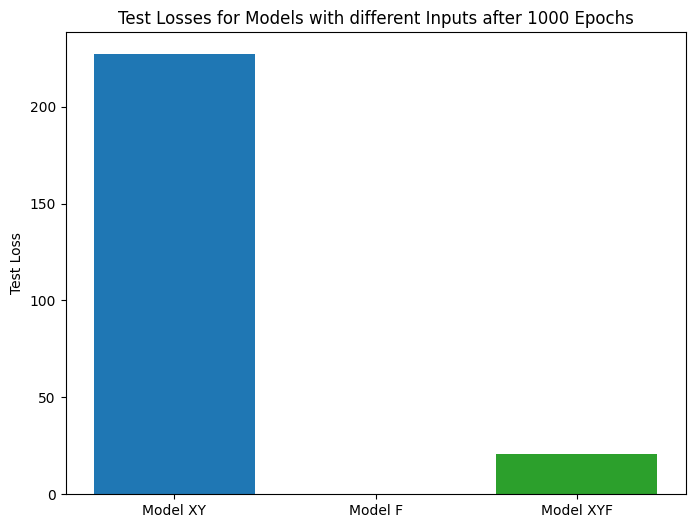

In [9]:
def plot_test_losses(test_losses: dict, epochs=0):
  plt.figure(figsize=(8, 6))
  for label, loss in test_losses.items():
      plt.bar(label, loss)
  plt.ylabel('Test Loss')
  plt.title(f'Test Losses for Models with different Inputs after {epochs} Epochs')
  plt.savefig(output, dpi=160)

plot_test_losses(test_losses, epochs=epochs)

**Conclusion:**
- The model trained on F and the model trained on XY outperform the model trained on XYF.
- We should use a seperate model for force estimation and position estimation.